# <strong> Example parameterised cradle-to-gate life cycle assessment: Linking BatPaC to Brightway </strong>

Following notebook provides three examples of the linkages between BatPaC to Brightway2 to calculate the cradle-to-gate life cycle emissions of different battery designs.


* [Example 1: Cradle to gate emission of a single battery design](#first-bullet)
* [Example 2: Cradle to gate emission  of several battery design](#second-bullet)
* [Example 3: Cradle to gate emission  of several battery design modular approach](#third-bullet)



<center><img src='../../docs/batpac_bw_link.jpg' width=800/></center>

In [1]:
#Import required packages

import brightway2 as bw
import numpy as np
import pandas as pd
import openpyxl
from bw2data.parameters import ActivityParameter, DatabaseParameter, ProjectParameter, Group, ParameterManager
import sys
import matplotlib.pyplot as plt

#Import the battery design module from a local path
local_path =r"C:\Users\Joris\OneDrive - Newcastle University\Python\Projects\Batt_Sust_Model-1\batt_sust_model" #ADD PATH
sys.path.insert(1, local_path)
from battery_design import battery_design as bd
import battery_emissions as bat_lca

#Local path to BatPaC version 5
path_batpac = r"C:\Users\Joris\OneDrive - Newcastle University\PhD\Models\battery_sustainability_model\Case study\BatPaC 5.0 - 8March2022.xlsm"#ADD PATH


In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# Example 1 - Cradle-to-gate of a single battery <a class="anchor" id="first-bullet"></a>




## Solve battery system in BatPaC:
First, the material content of a single battery is obtained. The design of the VW ID.4 pack is used. See also the [example battery design notebook](https://github.com/jbaars2/Batt_Sust_Model/blob/main/example%20notebooks/example_battery_design.ipynb).

In [61]:
#Establish battery system class of specific design:
battery = bd.Battery_system (    
                            vehicle_type='EV', 
                             electrode_pair='NMC622-G (Energy)',                              
                             cells_per_module=24, 
                             modules_per_row=6,
                             rows_of_modules=2, 
                             sep_film_thickness = 17,
                             negative_foil_thickness = 12,
                             positive_foil_thickness = 14,
                             positive_electrode_thickness = 87.3,
                             cells_in_parallel=3, #https://static.nhtsa.gov/odi/tsbs/2021/MC-10186407-0001.pdf
                             modules_in_parallel = 1,  
                             silicon_anode= 0.00, 
                             calculate_fast_charge = 'Yes',
                             max_charging_time = 33,  
                             max_charge_power = 135, 
                             available_energy=94,
                             A_coefficient=135.9999272, #based on EPA data
                             B_coefficient= 3.732390689,#based on EPA data
                             C_coefficient=0.406771986,#based on EPA data
                             vehicle_range_miles =410*0.6214, #EV-database using the 'EVDB Real Range' (converted to miles) https://ev-database.org/car/1273/Volkswagen-ID4-1st
                             motor_power = 150 #Based on adac.de VW ID.4 Pro Performance https://www.adac.de/rund-ums-fahrzeug/autokatalog/marken-modelle/vw/id4/1generation/318521/#technische-daten                 
                             )
#Establish parameter dictionary
parameter_dict = battery.parameter_dictionary()

In [63]:
# #Solve battery design in BatPaC returning nested dictionary with material contents and parameter values
# #Make sure BatPaC is not open or running in the background
result_dict = bd.solve_batpac_battery_system (batpac_path = path_batpac, parameter_dict=parameter_dict, visible=False)

## Import Brightway databases
Brightway databases are imported containing parameterised inventories and default project parameters:


In [55]:
#Brightway2 general setup:
bw.projects.set_current('parameterised_battery_lca')
bw.bw2setup()
#Import ecoinvent 3.7.1:
if 'eidb 3.7' in bw.databases:
    pass
else:
    pathi37 = 'path to ecoinvent'
    eidb37 = bw.SingleOutputEcospold2Importer(pathi37, 'eidb 3.7')
    eidb37.apply_strategies()
    eidb37.statistics()
    
#Battery LCA setup:
# Import all Brightway2 databases (BW2Package format) required for the battery LCA: 
bat_lca.import_db_brightway()

# Import all project parameters and include default values such as process yield and energy consumption
bat_lca.import_project_parameters()

# # Import the BW activity functions CHECK IF NEEDED IF THE BW2PACKAGES ARE UPLOADED!!!!
# df_act_functions = pd.read_excel(r"C:\Users\Joris\OneDrive - Newcastle University\Python\Projects\Batt_Sust_Model-1\batt_sust_model\data\process_formulas.xlsx", sheet_name = 'activity_functions_cut_off')

# bat_lca.import_activity_functions    (df_act_functions)

Biosphere database already present!!! No setup is needed
anode_material  already present
anode_materials  already present
battery_production  already present
cathode  already present
cathode_material  already present
cell_container  already present
cell_other  already present
current_collectors  already present
electrolyte  already present
manufacturing_waste_scrap  already present
module  already present
pack  already present
separator  already present
separators  already present


All battery production activities contain formulas with Brightway project parameters. 
 <br>For example, the activity "mixing cathode materials" in the "battery_production" database contains the following exchanges, formulas and default amounts:

In [102]:
act_cat_mixing = [act for act in bw.Database('battery_production') if act['name']=='mixing cathode materials'][0] 
input = [bw.get_activity(exc['input'])['reference product'] for exc in act_cat_mixing.exchanges()]
formula = [exc['formula'] for exc in act_cat_mixing.exchanges()]
amount = [round(exc['amount'], 2) for exc in act_cat_mixing.exchanges()]
unit = [bw.get_activity(exc['input'])['unit'] for exc in act_cat_mixing.exchanges()]
df_cath_mixing = pd.DataFrame()
df_cath_mixing[['Input product', 'Activity formula', 'Default amount', 'Unit']] = np.array([input, formula, amount, unit]).T
pd.options.display.max_colwidth = 100
df_cath_mixing

,Input product,Activity formula,Default amount,Unit
0,cathode slurry,cathode_slurry,218.48,kilogram
1,binder solvent (NMP),(binder_solvent_nmp/py_am_mixing_total)-binder_solvent_recovered,1.07,kilogram
2,cathode active material (LFP),cathode_active_material_lfp/py_am_mixing_total,0.0,kilogram
3,cathode active material (LMO),cathode_active_material_lmo/py_am_mixing_total,0.0,kilogram
4,cathode active material (NCA),cathode_active_material_nca/py_am_mixing_total,0.0,kilogram
5,cathode active material (NMC333),cathode_active_material_nmc333/py_am_mixing_total,0.0,kilogram
6,cathode active material (NMC532),cathode_active_material_nmc532/py_am_mixing_total,0.0,kilogram
7,cathode active material (NMC622),cathode_active_material_nmc622/py_am_mixing_total,143.15,kilogram
8,cathode active material (NMC811),cathode_active_material_nmc811/py_am_mixing_total,0.0,kilogram
9,cathode binder (PVDF),cathode_binder_pvdf/py_am_mixing_total,2.98,kilogram


## Update Brightway project parameters
The battery design outputs are used as change the project parameters in Brightway and update the activities amounts accordingly

In [103]:
#Change BatPaC output to Brightway project names (non-alphanumeric keys)
battery_design_param = bat_lca.output_as_bw_param(result_dict)


#Update the project parameters and recalculate activity amounts in Brightway:
bat_lca.update_param_battery_bw(battery_design_param)



In [104]:
amount_updated = [round(exc['amount'], 2) for exc in act_cat_mixing.exchanges()]

if 'Updated amount' not in df_cath_mixing.columns:
    df_cath_mixing.insert(3, 'Updated amount', 0) 

df_cath_mixing['Updated amount'] = pd.DataFrame(amount_updated)


df_cath_mixing

,Input product,Activity formula,Default amount,Updated amount,Unit
0,cathode slurry,cathode_slurry,218.48,218.48,kilogram
1,binder solvent (NMP),(binder_solvent_nmp/py_am_mixing_total)-binder_solvent_recovered,1.07,1.07,kilogram
2,cathode active material (LFP),cathode_active_material_lfp/py_am_mixing_total,0.0,0.00,kilogram
3,cathode active material (LMO),cathode_active_material_lmo/py_am_mixing_total,0.0,0.00,kilogram
4,cathode active material (NCA),cathode_active_material_nca/py_am_mixing_total,0.0,0.00,kilogram
5,cathode active material (NMC333),cathode_active_material_nmc333/py_am_mixing_total,0.0,0.00,kilogram
6,cathode active material (NMC532),cathode_active_material_nmc532/py_am_mixing_total,0.0,0.00,kilogram
7,cathode active material (NMC622),cathode_active_material_nmc622/py_am_mixing_total,143.15,143.15,kilogram
8,cathode active material (NMC811),cathode_active_material_nmc811/py_am_mixing_total,0.0,0.00,kilogram
9,cathode binder (PVDF),cathode_binder_pvdf/py_am_mixing_total,2.98,2.98,kilogram


## Calculate environmental impacts in Brightway

In [105]:
lcia_results = {}

#Calculate emissions for all ReCiPe midpoint V.1.13
methods = [method for method in bw.methods if 'ReCiPe Midpoint (H) V1.13 no LT' in str(method)]

# Set up LCI in Brightway with total pack weight as function unit:
battery_production =bw.Database('battery_production').get(('025dcd4c91fc4eeda276f5fff9ad198e_copy5'))
fu = {battery_production: battery_design_param['battery_pack']}
pack_lca = bw.LCA(fu, methods[0])
pack_lca.lci()
pack_lca.lcia()

# Calculate scores:
for impact_category in methods:
    pack_lca.switch_method(impact_category)
    pack_lca.lcia()
    lcia_results [impact_category] = {}
    lcia_results [impact_category]['score'] = pack_lca.score
    lcia_results [impact_category]['unit'] = bw.Method(impact_category).metadata['unit']

In [106]:
df_total = pd.DataFrame.from_dict(lcia_results).T
df_impact_single = pd.DataFrame()
df_impact_single['score pack'] = df_total['score'].astype(float).round(2)
df_impact_single['score kWh'] = (df_total['score']/battery_design_param['battery_capacity']).astype(float).round(4)
df_impact_single['score kg'] = (df_total['score'].astype(float).round(2)/battery_design_param['battery_pack']).astype(float).round(4)
df_impact_single['unit'] = df_total['unit'] 
df_impact_single


score pack  \
ReCiPe Midpoint (H) V1.13 no LT metal depletion                 MDP        11057.82   
                                agricultural land occupation    ALOP         357.97   
                                climate change                  GWP100      6219.04   
                                fossil depletion                FDP         2117.12   
                                freshwater ecotoxicity          FETPinf       21.27   
                                freshwater eutrophication       FEP            0.44   
                                human toxicity                  HTPinf      2161.19   
                                ionising radiation              IRP_HE       741.87   
                                marine ecotoxicity              METPinf       30.80   
                                marine eutrophication           MEP            3.21   
                                natural land transformation     NLTP          -1.22   
                                ozone depletion                 ODPinf         0.00   
                                particulate matter formation    PMFP          20.52   
                                photochemical oxidant formation POFP          26.47   
                                terrestrial acidification       TAP100        53.19   
                                terrestrial ecotoxicity         TETPinf        2.16   
                                urban land occupation           ULOP         121.05   
                                water depletion                 WDP          484.95   

                                                                         score kWh  \
ReCiPe Midpoint (H) V1.13 no LT metal depletion                 MDP       125.7688   
                                agricultural land occupation    ALOP        4.0715   
                                climate change                  GWP100     70.7337   
                                fossil depletion                FDP        24.0796   
                                freshwater ecotoxicity          FETPinf     0.2419   
                                freshwater eutrophication       FEP         0.0050   
                                human toxicity                  HTPinf     24.5808   
                                ionising radiation              IRP_HE      8.4379   
                                marine ecotoxicity              METPinf     0.3503   
                                marine eutrophication           MEP         0.0365   
                                natural land transformation     NLTP       -0.0139   
                                ozone depletion                 ODPinf      0.0000   
                                particulate matter formation    PMFP        0.2334   
                                photochemical oxidant formation POFP        0.3011   
                                terrestrial acidification       TAP100      0.6050   
                                terrestrial ecotoxicity         TETPinf     0.0245   
                                urban land occupation           ULOP        1.3768   
                                water depletion                 WDP         5.5158   

                                                                         score kg  \
ReCiPe Midpoint (H) V1.13 no LT metal depletion                 MDP       22.4220   
                                agricultural land occupation    ALOP       0.7259   
                                climate change                  GWP100    12.6104   
                                fossil depletion                FDP        4.2929   
                                freshwater ecotoxicity          FETPinf    0.0431   
                                freshwater eutrophication       FEP        0.0009   
                                human toxicity                  HTPinf     4.3822   
                                ionising radiation              IRP_HE     1.5043   
                   

#  LCA cradle-to-gate of several battery systems: size effect (Example 2)
To understand the impact of battery size on pack emissions, in the following example several designs with varying pack energy (30)

The following example calculates the emissions of different battery pack sizes ranging from 30 to 130 kWh (5 kWh step)

## Solve several battery systems in BatPaC

In [4]:
dict_design = {}

for energy in range(30, 130+1, 10):
    battery = bd.Battery_system ( vehicle_type='EV', 
                                electrode_pair='NMC622-G (Energy)', 
                                cells_per_module=24, 
                                modules_per_row=6,
                                rows_of_modules=2, 
                                cells_in_parallel=1,
                                silicon_anode= 0.00, 
                                pack_energy=energy, 
                                calculate_fast_charge = 'Yes',
                                max_charging_time = 33,  
                                max_charge_power = 135, 
                                available_energy=94)
    #Establish parameter dictionary
    parameter_dict = battery.parameter_dictionary()

    #Save each BatPaC output in design dictionary:
    dict_design[energy] = parameter_dict
    
#Solve in BatPaC. Make sure BatPaC is closed!
result_dict_all = bd.solve_batpac_battery_system_multiple (
    batpac_path = path_batpac,
    parameter_dict_all=dict_design, 
    visible=True)

100%|██████████| 11/11 [00:59<00:00,  5.43s/it]


In [5]:
df_mc_all = pd.DataFrame.from_dict([result_dict_all[x]['material_content_pack'] for x in result_dict_all.keys()])
df_mc_all['capacity'] = [result_dict_all[x]['general_battery_parameters']['pack_energy_kWh'] for x in result_dict_all.keys()]
df_mc_all = df_mc_all[df_mc_all>0].dropna(axis=1).set_index('capacity')
df_mc_all.T

capacity,30.0,40.0,50.0,60.0,70.0,80.0,90.0,100.0,110.0,120.0,130.0
anode active material (synthetic graphite),26.389262,34.921758,43.429169,51.919316,60.396842,68.864771,77.325203,85.779665,94.220140,102.664125,111.104751
anode binder (CMC),0.323134,0.427613,0.531786,0.635747,0.739553,0.843242,0.946839,1.050363,1.153716,1.257112,1.360466
anode binder additive (SBR),0.215423,0.285076,0.354524,0.423831,0.493035,0.562161,0.631226,0.700242,0.769144,0.838074,0.906978
anode current collector Cu (10um),10.360331,13.448738,16.502425,19.531641,22.542469,25.538875,28.523612,31.498685,34.462389,37.421730,40.374978
battery jacket,59.883673,63.989311,67.615269,70.900557,73.927748,76.750640,79.406600,81.922832,84.317328,86.610772,88.813648
battery jacket Al,20.512764,22.346814,23.970801,25.445603,26.807381,28.079697,29.278915,30.416949,31.501638,32.542112,33.542931
battery jacket Fe,38.303852,40.476513,42.391003,44.122135,45.714350,47.196604,48.589006,49.906198,51.157903,52.355181,53.503707
battery jacket insulation,1.067057,1.165983,1.253465,1.332819,1.406016,1.474339,1.538679,1.599686,1.657787,1.713479,1.767010
battery management system,3.577600,3.577600,3.577600,3.577600,3.577600,3.577600,3.577600,3.577600,3.577600,3.577600,3.577600
battery pack,242.683480,288.559184,332.907133,376.172235,418.618765,460.418897,501.692217,542.525786,584.180056,624.308680,664.154280


## Update parameters and solve LCA in Brightway
The life cycle emissions for each design are calculated in Brightway for each battery design. This is relatively time consuming as the project parameters are updated for each battery design. A faster approach is presented in example 3 below. 


In [6]:
lcia_results_all = {}

methods = [method for method in bw.methods if 'ReCiPe Midpoint (H) V1.13 no LT' in str(method)]

#Calculate emissions for GWP100 ReCiPe midpoint V.1.13
cc = [method for method in bw.methods if 'ReCiPe Midpoint (H) V1.13 no LT' in str(method) and 'climate change' in str(method)]

#Update Brightway parameters for each battery system:
for battery_design in result_dict_all.keys():
    result_dict_all[battery_design]['brightway_parameters'] = bat_lca.output_as_bw_param(result_dict_all[battery_design])
    battery = result_dict_all[battery_design]
    bat_lca.update_param_battery_bw(battery['brightway_parameters'])

    battery_production =bw.Database('battery_production').get(('025dcd4c91fc4eeda276f5fff9ad198e_copy5'))
    fu = {battery_production: battery['brightway_parameters']['battery_pack']}
    battery_lca = bw.LCA(fu, methods[2])
    battery_lca.lci()
    battery_lca.lcia()
    lcia_results_all [battery_design] = {}
    lcia_results_all [battery_design]['score'] = battery_lca.score
    lcia_results_all [battery_design]['unit'] = bw.Method(cc[0]).metadata['unit']
    lcia_results_all [battery_design]['capacity-kwh'] =battery['general_battery_parameters']['pack_energy_kWh']
    


The non-linear relation between the impact score and battery pack size is presented below. 

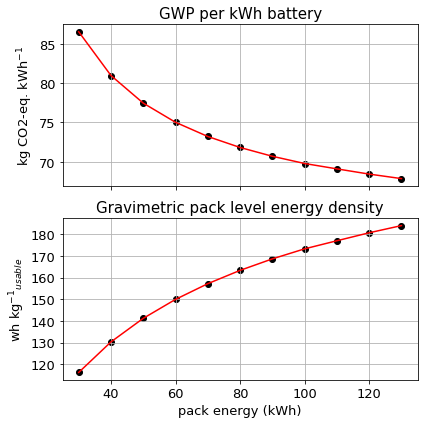

In [28]:
result_total = pd.DataFrame.from_dict(lcia_results_all)
emissions = list(result_total.loc['score']/result_total.loc['capacity-kwh'])

fig, ax = plt.subplots(2,1, sharex=True, figsize=(6,6))
ax[0].scatter(result_total.loc['capacity-kwh'], emissions,color='black')
ax[0].plot( result_total.loc['capacity-kwh'],emissions,color='r')
ax[1].scatter(result_total.keys(),[result_dict_all[x]['general_battery_parameters']['pack_usable_energy_kWh']/result_dict_all[x]['general_battery_parameters']['battery_system_weight']*1000 for x in result_dict_all.keys()], c='black')
ax[1].plot(result_total.keys(),[result_dict_all[x]['general_battery_parameters']['pack_usable_energy_kWh']/result_dict_all[x]['general_battery_parameters']['battery_system_weight']*1000 for x in result_dict_all.keys()], c='red')

ax[0].set_ylabel('kg CO2-eq. kWh$^{-1}$')
ax[1].set_ylabel(r'wh kg$^{-1}$$_{usable}$')
ax[1].set_xlabel('pack energy (kWh)')

for x in ax.flatten():
    for item in ([x.title, x.xaxis.label, x.yaxis.label] + x.get_xticklabels() + x.get_yticklabels()):
        item.set_fontsize(13)

ax[0].set_title('GWP per kWh battery', fontsize=15)
ax[1].set_title('Gravimetric pack level energy density', fontsize=15)
for x in ax.flatten():
    x.grid(True)

fig.tight_layout()

# Modular LCA single battery (Example 3)
The iterative calculation of multiple battery designs by changing the parameters in Brightway is relatively slow to solve many battery designs. 

<br>Instead, a more efficient way is the use of precalculated gate-to-gate LCA modules based on [Steubing et al., 2016](https://link.springer.com/article/10.1007/s11367-015-1015-3).

## Establish base product-module matrix ($A'$)



The first step is to establish the base product-module matrix ($A'$). 
To obtain this matrix, a new Brightway database is established containing all relevant modules that need to be cut-off and representing the foreground system






<!-- set to 1 kg and all battery-production processes set to 1 kg of battery (e.g. anode coating required for 1 kg of battery). 
 -->

In [53]:
importlib.reload(bat_lca)


bat_lca.df_cut_off_modules

,code,database,location
process,,,
market for nickel sulfate,bfd40ce0de8e581e1100fbc9e2bf5baa,eidb 3.7,GLO
"market for wastewater, average",ff1c8e1f34a25cccba366c1a2c8c47c4,eidb 3.7,Europe without Switzerland
"market for steel, low-alloyed",d98d23d7d3583d1497b2aef6f7ede9eb,eidb 3.7,GLO
"market for transport, freight, sea, container ship",e1e88d15018316431457dc849d8cf30b,eidb 3.7,GLO
market for manganese dioxide,585b0c03d77aba6ad7b36569b4dbbf06,eidb 3.7,GLO
...,...,...,...
battery jacket steel,0eb604062ce54cc58402135e2570dbdf,pack,GLO
battery jacket aluminium,4f65f316bc694e36b511130330d28926,pack,GLO
market for module elastomer pads,c958894bac5bd5fb29a0240d984d476a_copy1,pack,GLO


Establishing the new cut_off database:

In [56]:
# %%capture

activities= []
count = []
#check if db already established:


def format_me(list_of_activities, database_obj):
    return {(database_obj.name, obj['code']): obj for obj in list_of_activities}

if 'cut_off' in bw.databases:
    cut_off_db =  bw.Database('cut_off')
if 'cut_off' not in bw.databases:
    cut_off_db =  bw.Database('cut_off')
    cut_off_db.register()
    for row in bat_lca.df_cut_off_modules.iterrows():
        act = bw.Database(row[1]['database']).get(row[1]['code'])
        if act not in bw.Database('cut_off'):
            act.copy(database="cut_off")
            act.save()
        
    bat_lca.add_activity_parameters('cut_off')


next we relink the databases of the exchanges and corresponding activities to the "cut_off" database.

For now we use Activity Browser and relink exchanges to the 'cut_off' database.


Next, we cut off the exchanges if the activity is present in the 'cut off database'. 
E.g. 6um copper foil production is present in the 'cut of database' and will be cut in the anode coating process. 




In [109]:

a = bat_lca.modules_with_cuts('cut_off')

# Divide all battery production activities by total battery system weight:
bat_product_act = [act['name'] for act in bw.Database('battery_production')]
for act in bat_product_act:
    pack_weight = battery_design_param['battery_pack']
    a[act]['amount'] = a[act]['amount']/pack_weight
    for exc in a[act]['cuts'].keys():
        a[act]['cuts'][exc][1] = a[act]['cuts'][exc][1]/pack_weight
        
#Cut modules, setting all cut-off exchanges to zero:
bat_lca.cut_modules_to_zero(a)

Now the emissions of all modules can be calculated:

In [110]:
#Select all Recipe Midpoint impacts:
impacts = [m for m in bw.methods if 'ReCiPe Midpoint (H) V1.13' in str(m) and 'no LT' in str(m)]
H_m = bat_lca.lcia_modules (a, impacts)

In [81]:
df_H_modular = pd.DataFrame(H_m[:,:].T,index=impacts, columns=df_A_matrix.columns)
# df_H_modular

The total emissions of a pack can now be calculated by multiplying the module emissions ($\bf{h}$) with the scaling vector ($\bf{s}$):

$$ h= \mathbf{h} \mathbf{s}$$

where the scaling vector is calculated by the inverse of the foreground modular technology matrix ($\mathbf{A}$) and the final demand vector ($\mathbf{f}$) based on the general matrix LCA formula:

$$ \mathbf{s} = \mathbf{A}^{-1} \mathbf{f} $$



In [94]:
# Establish product-module dataframe of base system
df_A_matrix=bat_lca.modular_technology_matrix(a)

#Calculate for design 1:
pack_design =battery_design_param
#Parameter shortcuts:
pack_weight = battery_design_param['battery_pack']
capacity = battery_design_param['battery_capacity']

#Inverse the A' matrix:
A_inv = pd.DataFrame(np.linalg.pinv(df_A_matrix.values), df_A_matrix.columns, df_A_matrix.index)

#Establish final product demand vector for 1 battery based on pack weight
y = pd.Series(data = 0, index=df_A_matrix.index)
y.loc['battery pack'] = pack_weight

#Calculate scaling vector:
s = A_inv.dot(y)


In [95]:
# Emissions for all categories and modules:
h_all =  np.multiply(np.transpose([s]),H_m)


In [96]:
df_h=pd.DataFrame(h_all[:,2],df_A_matrix.columns, columns=[impacts[2]])
df_h.sort_values(by=impacts[2], ascending=False).head(10)/capacity

,"(ReCiPe Midpoint (H) V1.13 no LT, climate change, GWP100)"
market for cobalt hydroxide,14.756972
cathode active material (NMC333) import,10.662959
mixing cathode materials,10.662958
"market for aluminium, wrought alloy",8.434729
"market for copper, cathode",6.468114
"market group for electricity battery production, medium voltage",4.259923
anode active material (synthetic graphite) import,4.057225
Cobalt sulfate production,3.677300
market for nickel sulfate,3.447236
NMC333 precursor production,2.457852


In [97]:
df_h.sum()/capacity

(ReCiPe Midpoint (H) V1.13 no LT, climate change, GWP100)    86.112614
dtype: float64

## Establish environmental impact matrix of modules ($H_m$)
Precalculation of each cut-off module

In [ ]:
# list_fu = [
#         {bw.get_activity(a[act]["key"])['database']: a[act]["amount"]}
#         for act in a.keys()
#     ]

In [ ]:
# bw.calculation_setups["multi_lca"] = {"inv": list_fu, "ia": impacts}


In [ ]:
# MultiLCA = bw.MultiLCA("multi_lca")

Multiplication of the modular scaling factor ($s'$) with the modular emission matrix ($H_m$) to get the total emisions of the system ($h$). <br>
Scaling vector is calculated with the general LCA formula:<br>
$$s' = A'^{-1}y'$$
where $y'$ is the final demand vector.

In [ ]:
df_H_modular.to_excel(r"C:\Users\Joris\Downloads\output_h.xlsx")

In [ ]:
#Calculate for design 1:
pack_design =battery_design_param
#Parameter shortcuts:
pack_weight = battery_design_param['battery_pack']
capacity = battery_design_param['battery_capacity']

#Inverse the A' matrix:
A_inv = pd.DataFrame(np.linalg.pinv(A_prime.values), A_prime.columns, A_prime.index)

#Establish final product demand vector for 1 battery based on pack weight
y_prime = pd.Series(data = 0, index=A_prime.index)
y_prime.loc['battery pack'] = pack_weight

#Calculate scaling vector:
s_prime = A_inv.dot(y_prime)


Error: Canceled future for execute_request message before replies were done

## Calculate total emissions of the system ($h$)

Multiplication of the scaling vector with the pre-calculated emissions of the modules:

$$h=s'H_m$$

342.3531389264103

Top 10 LCA modules with highest CO2-eq emissions:

,"(ReCiPe Midpoint (H) V1.13 no LT, climate change, GWP100)"
market for cobalt hydroxide,14.751740
mixing cathode materials,10.657194
cathode active material (NMC333) import,10.657194
"market for aluminium, wrought alloy",8.427941
"market for copper, cathode",6.460284
"market group for electricity battery production, medium voltage",4.253779
anode active material (synthetic graphite) import,4.049051
Cobalt sulfate production,3.673718
market for nickel sulfate,3.446243
NMC333 precursor production,2.456728


Total GWP value:

In [ ]:
df_h.sum()

(ReCiPe Midpoint (H) V1.13 no LT, climate change, GWP100)    6224.329575
dtype: float64

In [ ]:
df_h.to_excel(r"C:\Users\Joris\Downloads\output_h.xlsx")

In [ ]:
modules_dict =a

for module in modules_dict.keys():
    if modules_dict[module]["cuts"]:
        act = bw.get_activity(modules_dict[module]["key"])
        cut_exchanges = [
            exc
            for exc in act.exchanges()
            if exc["input"] in modules_dict[module]["cuts"].keys()
        ]
        for cut_exc in cut_exchanges:
            try:  # Exchanges with formulas
                if cut_exc["formula"] is not None:
                    cut_exc["amount"] = 0  # Amount to zero for cut-off modules
                    cut_exc.save()
            except KeyError:  # If exchange has no formula, set formula to amount
                print (cut_exc)
                # make new activity parameter:
                cut_exc["formula"] = cut_exc["amount"]
                cut_exc.save()
                bw.parameters.add_exchanges_to_group("my group", act)
                cut_exc["amount"] = 0
                cut_exc.save()


pd.DataFrame(module_dict.values(), index= module_dict.keys()).to_clipboard()

Visualise emissions by module:

In [ ]:
#Import process and product category mapping:
category_mapping=pd.read_excel(r"C:\Users\Joris\OneDrive - Newcastle University\PhD\Models\ME optimisation model\ME_battery_supply_chain\Model\data\process_product_type_contribution.xlsx", sheet_name='values').fillna(0)


def plot_module_impact (df_lcia_modules, df_category_mapping, title=None):
    """ Plot the impact of modules per module category"""
    df = df_category_mapping
    df.set_index('process', inplace=True)
    df=df.join(df_lcia_modules).groupby(['component category']).sum()
    category = df_lcia_modules.columns[0]
#     df.insert(loc=0, column='battery_system', value=lcia_modules)   
    df=df.sort_values(by=category, ascending=False)
    axes = df.T.plot.bar(stacked=True, legend=True, fontsize=14, figsize=(12,8), zorder=3)
    axes.grid(zorder=0, axis='y')
    axes.set_title(f'{title} \n CO2-eq emissions per kWh', fontsize=18)
    axes.set_ylabel('kg CO2-eq', fontsize = 14)
    axes.legend(loc='center left',bbox_to_anchor=(1.0, 0.5), fontsize=14)
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()



f = plot_module_impact(df_h/capacity,category_mapping, title=f'{round(capacity)} kWh')


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Joris\\OneDrive - Newcastle University\\PhD\\Models\\ME optimisation model\\ME_battery_supply_chain\\Model\\data\\process_product_type_contribution.xlsx'

## Modular LCA for multiple batteries


In [ ]:
battery = bd.Battery_system ( vehicle_type='EV', electrode_pair='NMC622-G', cells_per_module=24, modules_per_row=6,rows_of_modules=2, 
                             cells_in_parallel=1,silicon_anode= 0.00, pack_energy=82, available_energy=94).parameter_dictionary()
battery_designs_params=battery

In [ ]:
dict_result = bd.solve_batpac_battery_system (batpac_path = path_batpac, parameter_dict=battery, visible=False)

In [ ]:
# chemistry range
cath      = ['NMC333-G', 'NMC532-G','NMC622-G', 'NMC811-G','NCA-G','LFP-G','NMC532/50%/LMO  - G', 'LMO-G']
battery_designs_params = {}

# Establish a dictionary with a class of all battery designs:
for x in cath:
    name = f'{x} 23.5'
    battery = bd.Battery_system ( vehicle_type='EV', electrode_pair=x, cells_per_module=24, modules_per_row=6,rows_of_modules=2, 
                             cells_in_parallel=1,silicon_anode= 0.00, pack_energy=82, available_energy=94).parameter_dictionary()
    battery_designs_params[name]=battery

# Solve all battery systems in BatPaC.
result_dict_all = bd.solve_batpac_battery_system_multiple (batpac_path = path_batpac, parameter_dict_all=battery_designs_params, visible=False)

from tabulate import tabulate
headers = result_dict_all.keys()
data = [
        ['kWh', *[result_dict_all[pack]['general_battery_parameters']['pack_energy_kWh'] for pack in result_dict_all.keys()]]
       ]

for battery_design in result_dict_all.keys():
    battery = result_dict_all[battery_design]
    result_dict_all[battery_design]['brightway_parameters'] = bat_lca.output_as_bw_param(result_dict_all[battery_design])

print(tabulate(data, headers=headers))


In [ ]:
path_comp_type_linkage = r"C:\Users\Joris\OneDrive - Newcastle University\PhD\Models\ME optimisation model\ME_battery_supply_chain\Model\data\component_type_linkage.xlsx"

df_types = pd.read_excel(path_comp_type_linkage, index_col='component')

In [ ]:
result = result_dict_all['NMC333-G 23.5']['material_content_pack']

df_types['result'] = df_types.index.map(result).fillna(0)
df_types = df_types[(df_types != 0).all(1)]
df_types = df_types.groupby(['component_type', 'part_off']).sum()
df_types.sort_values(by='part_off', ascending=True, inplace=True)
df_types = df_types.reset_index(level=[1])

In [ ]:
df = df_types.drop('part_off', axis=1).sort_values(by='result', ascending=False)
df.T.plot.bar(stacked=True)

## Update parameter and activity formulas 

The activity and parameter formulas need to be calculcated for each battery design system. To improve the calculation speed, this is done outside of Brightway using the functions below. The Brightway formula strings are stored in a separate 

## Calculate emissions and visualise results

In [ ]:
total_emission_kwh = []
module_emissions = {}

for key in result_dict_all.keys():
    
    capacity = result_dict_all[key]['brightway_parameters']['battery_capacity']
    pack_weight = result_dict_all[key]['brightway_parameters']['battery_pack']
    A_prime_temp = update_parameterised_modules(A_prime,result_dict_all[key], func_dict)
    
    #Inverse the A' matrix:
    A_inv = pd.DataFrame(np.linalg.pinv(A_prime_temp.values), A_prime_temp.columns, A_prime_temp.index)

    #Establish final product demand vector for 1 battery based on pack weight
    y_prime = pd.Series(data = 0, index=A_prime_temp.index)
    y_prime.loc['battery pack'] = pack_weight

    #Calculate scaling vector:
    s_prime = A_inv.dot(y_prime)
    # GWP100:
    emission = H_m[:,2]*s_prime
    module_emissions[key]=emission

    total_emission_kwh.append(emission.sum()/capacity)
    
#Plot total emissions
plt.bar(result_dict_all.keys(), total_emission_kwh)
plt.xticks( rotation='vertical')



In [ ]:
category_mapping=pd.read_excel(r"C:\Users\Joris\OneDrive - Newcastle University\PhD\Models\ME optimisation model\ME_battery_supply_chain\Model\data\process_product_type_contribution.xlsx", sheet_name='values').fillna(0)
category_mapping.set_index('process', inplace=True)

       
df = category_mapping.groupby(['aggregated']).sum()


for key in module_emissions.keys():

        df_module_emission = pd.DataFrame(module_emissions[key])
        df_temp =category_mapping.join(df_module_emission).groupby(['aggregated']).sum()
        df[key]=df_temp

        

ax=(df/capacity).sort_values(by=list(result_dict_all.keys())[0], ascending=False).T.plot.bar(stacked=True)
ax.legend(bbox_to_anchor=(1.1, 1.05))
ax.set_ylabel('GWP100 impact [kg CO2-eq]')


In [ ]:
openpyxl.load_workbook(r'3_MC_battery_pack_material.xlsx')

# calculate battery design

In [ ]:
import itertools
from tqdm.notebook import tqdm

cath      = ['NMC333-G', 'NMC532-G','NMC622-G', 'NMC811-G','NCA-G','LFP-G','NMC532/50%/LMO  - G']
ano       = ['synthetic', 'natural']
sil       = [0.0,0.08]
cell_mod  = [12,34]  # Based on min and max values in BatPaC
energy    =  [75]
battery_designs_params = {}
count = 0
for cat, an, si, cell, ene in tqdm(itertools.product(cath, ano, sil, cell_mod, energy)):
#     print (count, cat, an, si, cell, ene)

    
    battery = bd.Battery_system ( vehicle_type='EV', electrode_pair=cat, 
                                            silicon_anode= si, pack_energy = ene, graphite_type=an,cells_per_module=cell ).parameter_dictionary()
    count +=1

    battery_designs_params[count]=battery

# result_dict_all = bd.solve_batpac_battery_system_multiple (batpac_path = path_batpac, parameter_dict_all=battery_designs_params, visible=False)


In [ ]:
result_dict_all = bd.solve_batpac_battery_system_multiple (batpac_path = path_batpac, parameter_dict_all=battery_designs_params, visible=True)


In [ ]:
#Establish correpsonding processs emissions matrix H:

df_emission = pd.DataFrame(impact_all, index=A.columns, columns=impacts).T

In [ ]:
def calculate_modular_A (technology_matrix_default, pre_calculated_modules, battery_design_dictionary, name,  production_act, reference_prod):  
    
    updated_act = update_formulas(battery_design_dictionary)
    battery_weight = battery_design_dictionary['brightway_parameters']['battery_pack']
    capacity = battery_design_dictionary['brightway_parameters']['battery_capacity']
    A_matrix = technology_matrix_default.copy(deep=True) # To make sure the default A dataframe is not modified
    h = pre_calculated_modules.copy(deep=True) 
    
    
    # Establish A frame for battery production. Production processes and process outputs (reference products) have unique name, except battery pack
    for idx in A_matrix.index:
        for col in A_matrix.columns:
            if (col, idx) in updated_act.keys() and col in production_act:
                A_matrix.loc[idx, col] = updated_act[(col, idx)]
            elif  (col, idx) in updated_act.keys():
                A_matrix.loc[idx, col] = updated_act[(col, idx)]
                
    #Battery pack in unit, not kg:
    A_matrix.loc['battery pack', 'module and pack assembly']=1
     
    #Unique name for battery production processes and products:
    bat_product_act_unique = [act +f' {name}' for act in production_act]
    reference_prod_unique = [product+f' {name}' if product !='battery pack' else product for product in reference_prod]
    new_act_names = dict(zip(production_act,bat_product_act_unique))
    new_prod_names = dict(zip(reference_prod, reference_prod_unique))
    
    A_matrix.rename(columns=new_act_names, inplace=True)
    A_matrix.rename(index=new_prod_names, inplace = True)
    h.rename(columns=new_act_names, inplace=True)    
    return A_matrix[bat_product_act_unique], h[bat_product_act_unique]

In [ ]:
# Calculate all process parameters for specfici design:
#Get battery production activities and reference products:
production_act = []
reference_prod  = []
for act in bw.Database('battery_production'):
    production_act.append(act['name'])
    for exc in act.exchanges():
        if exc['type'] == 'production':
            reference_prod.append(bw.get_activity(exc['input'])['reference product'])


A_wo_production = A.drop(production_act, axis=1).drop(reference_prod)
h_wo_production = df_emission.drop(production_act, axis=1)

list_df_A = []
list_df_h = []
for x in result_dict_all.keys():
    df_A, df_h = calculate_modular_A(A,df_emission,result_dict_all[x], x, production_act,reference_prod )
    list_df_A.append(df_A)
    list_df_h.append(df_h)
prod_df = pd.concat(list_df_A, axis=1).fillna(0)
h_array = pd.concat(list_df_h, axis=1)
A_non_square = pd.concat([prod_df,A_wo_production], axis=1).fillna(0)
h_non_square = pd.concat([h_array, h_wo_production], axis=1).fillna(0)


In [ ]:
df.to_excel('3_PAR_battery_design_parameters.xlsx')

In [ ]:
import pickle

a = {'hello': 'world'}

# with open(r'C:\Users\Joris\OneDrive - Newcastle University\PhD\Models\ME optimisation model\ME_battery_supply_chain\Data\Data dump\50_battery.pickle', 'wb') as handle:
#     pickle.dump(result_dict_all, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(r'C:\Users\Joris\OneDrive - Newcastle University\PhD\Models\ME optimisation model\ME_battery_supply_chain\Data\Data dump\battery_all.pickle', 'rb') as handle:
    result_dict_all = pickle.load(handle)

weight = []

for x in result_dict_all.keys():
    weight.append(result_dict_all[x]['material_content_pack']['battery pack'])
    
weight.sort()
plt.plot(weight)

In [ ]:
for battery_design in result_dict_all.keys():
    battery = result_dict_all[battery_design]
    result_dict_all[battery_design]['design_parameters'] = bat_lca.output_as_bw_param(result_dict_all[battery_design])

In [ ]:
A_non_square.to_csv(r'C:\Users\Joris\OneDrive - Newcastle University\PhD\Models\ME optimisation model\ME_battery_supply_chain\Data\Data dump\4_upi_non_square.csv')
h_non_square.to_csv(r'C:\Users\Joris\OneDrive - Newcastle University\PhD\Models\ME optimisation model\ME_battery_supply_chain\Data\Data dump\4_pe_non_square.csv')

In [ ]:
charging_time = list(range(5,42,1))

bat_dict_all = {}
count = 0
for time in charging_time:
    #Establish battery system class of specific design:
    battery = bd.Battery_system ( vehicle_type='EV', electrode_pair='NMC622-G', cells_per_module=24, modules_per_row=6,rows_of_modules=2, 
                             cells_in_parallel=1,silicon_anode= 0.00, pack_energy=84, available_energy=94, sep_foil_thickness=9, sep_coat_thickness=3, max_charging_time=time)
    bat_dict_all[count] = battery.parameter_dictionary()
    count+=1

    
result_dict_all = bd.solve_batpac_battery_system_multiple (batpac_path = path_batpac, parameter_dict_all=bat_dict_all, visible=False)


In [ ]:
with open(r'C:\Users\Joris\OneDrive - Newcastle University\PhD\Written parts\Figures\Figure data\Appendix_data\charging_time_sensitivity.pickle', 'rb') as handle:
    result_dict_all = pickle.load(handle)
charging_time = list(range(5,42,1))

pack_weight = []
electrode = []

for k,v in result_dict_all.items():
    electrode.append(v['general_battery_parameters']['positive_electride_thickness'])
    pack_weight.append(v['material_content_pack']['battery pack'])


fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.scatter(charging_time[0:41-15], pack_weight[0:41-15], label='Battery weight', s=10)
ax1.plot(charging_time[0:41-15], pack_weight[0:41-15], linewidth=1.2)

ax2.scatter(charging_time[0:41-15], electrode[0:41-15], c='r', label='Positive electrode thickness', s=10)
ax2.plot(charging_time[0:41-15], electrode[0:41-15], c='r', linewidth=1.2)

ax1.set_ylabel('Battery weight (kg)')
ax2.set_ylabel ('Electrode thickness (μm)')
ax1.set_xlabel ('Charge time 15-75% SOC (min)')
fig.legend()